In [ ]:
import pandas as pd
from google.colab import drive

train_path = "/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/descripcion_ejercicio3_train.xlsx"
val_path = "/content/drive/MyDrive/Documentos personales/9-Documentos Doctorado/Doctorado 2023/7-Clases/SRGVUA/rawdata/descripcion_ejercicio3_test.xlsx"

drive.mount('/content/drive')

train_data = pd.read_excel(train_path)
val_data = pd.read_excel(val_path)

df = train_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,Unnamed: 0,Description,EstContemp_calidad
0,1034,VIVIENDAS DE NUEVA CONSTRUCCIÓNUBICACIÓN EXCLU...,0.835429
1,1411,Piso para entrar a vivir en Canyadó a pocos me...,0.473125
2,931,"Piso en zona Diagonal-Colomeres, 94 m2 según c...",0.390436
3,5060,Piso todo exterior a reformar en zona Montorne...,0.169570
4,2803,AMPLIO ESTUDIO PARA PRIMERA VIVIENDA Y TAN SOL...,0.402005


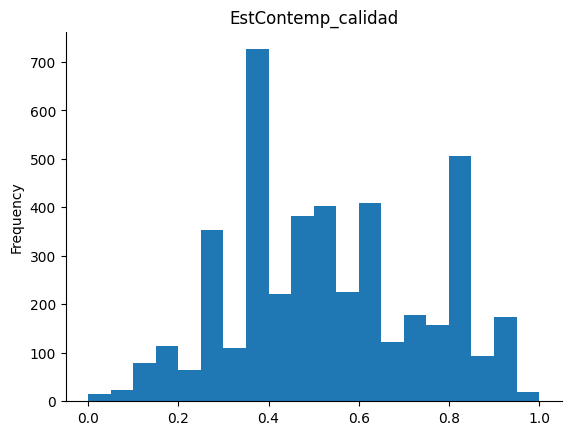

In [ ]:
# @title EstContemp_calidad

from matplotlib import pyplot as plt
df['EstContemp_calidad'].plot(kind='hist', bins=20, title='EstContemp_calidad')
plt.gca().spines[['top', 'right',]].set_visible(False)

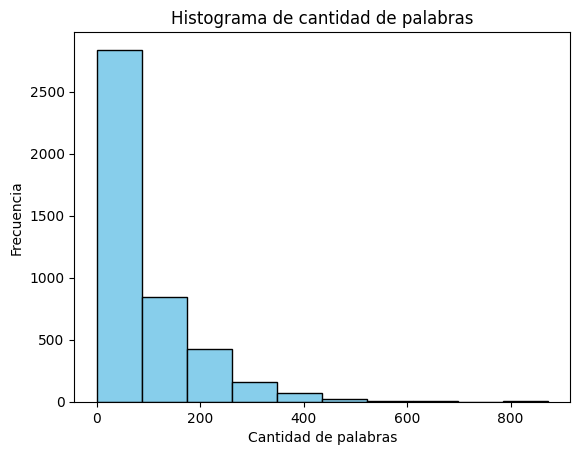

In [ ]:
# Verificar y manejar valores faltantes
df['Description'] = df['Description'].fillna('')  # Reemplazar NaN con una cadena vacía

# Dividir cada elemento de la columna 'Description' en palabras y contar la cantidad de palabras
df['cantidad_palabras'] = df['Description'].apply(lambda x: len(x.split()))

# Crear un histograma de la cantidad de palabras
plt.hist(df['cantidad_palabras'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Cantidad de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de palabras')
plt.show()

In [ ]:
df['Description'] = df['Description'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4373 entries, 0 to 4372
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          4373 non-null   int64  
 1   Description         4373 non-null   object 
 2   EstContemp_calidad  4373 non-null   float64
 3   cantidad_palabras   4373 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 136.8+ KB


In [ ]:
import re

def treat_euro(text):
    text = re.sub(r'(euro[^s])|(euros)|(€)', ' euros', text)
    return text

def treat_m2(text):
    text = re.sub(r'(m2)|(m²)', ' m²', text)
    return text

In [ ]:
def filter_ibans(text):
    pattern = r'ES\d{2}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{4}[ ]\d{2}|ES\d{20}|ES[ ]\d{2}[ ]\d{3}[ ]\d{3}[ ]\d{3}[ ]\d{5}'
    text = re.sub(pattern, '', text)
    return text

def remove_space_between_numbers(text):
    text = re.sub(r'(\d)\s+(\d)', r'\1\2', text)
    return text

def filter_emails(text):
    pattern = r'(?:(?!.*?[.]{2})[a-zA-Z0-9](?:[a-zA-Z0-9.+!%-]{1,64}|)|\"[a-zA-Z0-9.+!% -]{1,64}\")@[a-zA-Z0-9][a-zA-Z0-9.-]+(.[a-z]{2,}|.[0-9]{1,})'
    text = re.sub(pattern, '', text)
    return text

def filter_ref(text):
    pattern = r'(\(*)(ref|REF)(\.|[ ])\d+(\)*)'
    text = re.sub(pattern, '', text)
    return text

def filter_websites(text):
    pattern = r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*'
    text = re.sub(pattern, '', text)
    return text

def filter_phone_numbers(text):
    pattern = r'(?:(?:\+|00)33[\s.-]{0,3}(?:\(0\)[\s.-]{0,3})?|0)[1-9](?:(?:[\s.-]?\d{2}){4}|\d{2}(?:[\s.-]?\d{3}){2})|(\d{2}[ ]\d{2}[ ]\d{3}[ ]\d{3})'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(u'\xa0', u' ')
    text = treat_m2(text)
    text = treat_euro(text)
    text = filter_phone_numbers(text)
    text = filter_emails(text)
    text = filter_ibans(text)
    text = filter_ref(text)
    text = filter_websites(text)
    text = remove_space_between_numbers(text)
    return text

df['cleaned_description'] = df.Description.apply(clean_text)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('pysentimiento/robertuito-sentiment-analysis')

# Tokenizar las descripciones
encoded_corpus = tokenizer(text=df.cleaned_description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)

# Obtener los input_ids y attention_mask después de la tokenización
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']


In [ ]:
import numpy as np

def filter_long_descriptions(tokenizer, descriptions, max_len):
    indices = []
    for i, description in enumerate(descriptions):
        # Obtener la longitud de la descripción después de la tokenización
        length = len(tokenizer.tokenize(description))
        if length <= max_len - 2:  # Restar 2 para tener en cuenta los tokens especiales [CLS] y [SEP]
            indices.append(i)
    return indices

# Filtrar las descripciones largas
short_descriptions = filter_long_descriptions(tokenizer,
                                              df.cleaned_description.tolist(),
                                              300)

# Seleccionar los input_ids, attention_mask y labels correspondientes a las descripciones cortas
input_ids = np.array(input_ids)[short_descriptions]
attention_mask = np.array(attention_mask)[short_descriptions]
labels = df.EstContemp_calidad.to_numpy()[short_descriptions]

Token indices sequence length is longer than the specified maximum sequence length for this model (435 > 128). Running this sequence through the model will result in indexing errors


In [ ]:
from sklearn.model_selection import train_test_split

test_size = 0.1
seed = 42

#Los labels son 'EstContemp_calidad'
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, labels, test_size=test_size,
    random_state=seed)

train_masks, test_masks, _, _ = train_test_split(attention_mask,
                                        labels, test_size=test_size,
                                        random_state=seed)

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32 #Inicialmente era 32

def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)

test_dataloader = create_dataloaders(test_inputs, test_masks,
                                     test_labels, batch_size)

In [ ]:
import torch.nn as nn
from transformers import RobertaModel

class RobertaRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_roberta=False):

        super(RobertaRegressor, self).__init__()
        D_in, D_out = 768, 1  # Esto puede variar dependiendo del modelo RoBERTa que estés utilizando

        self.roberta = RobertaModel.from_pretrained('pysentimiento/robertuito-sentiment-analysis')
        if freeze_roberta:
            for param in self.roberta.parameters():
                param.requires_grad = False

        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))

    def forward(self, input_ids, attention_mask):

        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]  # Tomamos la representación de la primera posición (CLS) de la secuencia
        logits = self.regressor(pooled_output)
        return logits

# Instancia del modelo
model = RobertaRegressor(drop_rate=0.2)


config.json:   0%|          | 0.00/925 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/435M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

model.to(device)

Using GPU.


RobertaRegressor(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30002, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
loss_function = nn.MSELoss()

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm

def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):
            print(step)
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            # Convertir los tensores de salida y etiquetas al tipo de dato correcto
            outputs = outputs.float()
            batch_labels = batch_labels.float()
            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze())
            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

    return model

# Llama a la función train nuevamente con los tensores convertidos
model = train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader, device, clip_value=2)

0
-----
0


RuntimeError: The expanded size of the tensor (300) must match the existing size (130) at non-singleton dimension 1.  Target sizes: [32, 300].  Tensor sizes: [1, 130]